In [59]:
# we load the things!

from ngsolve import *
from ngsolve.webgui import Draw
from netgen.csg import *
from ngsolve.fem import LeviCivitaSymbol, Einsum

import scipy.sparse as sp
from scipy.optimize import curve_fit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

Some operators on coefficient functions to softe the load of hodge laplacian computations of manufactured solutions and some more..

In [60]:
# functions for differential operators on manufactured solutions 

coords = [x,y,z]

def JacobianOfCF(cf):
    """ Function to compute the Jacobi Matrix of a vector coefficient function cf """

    Jac_u_3D = CF((
    cf[0].Diff(x), cf[0].Diff(y), cf[0].Diff(z),
    cf[1].Diff(x), cf[1].Diff(y), cf[1].Diff(z),
    cf[2].Diff(x), cf[2].Diff(y), cf[2].Diff(z)
    ), dims=(3, 3))

    return Jac_u_3D

def GGrad(cf):
    """ Function to compute the gradient of a scalar Coefficient Function """
    gg = [cf.Diff(coords[i]) for i in range(mesh.dim)]
    return CF(tuple(gg))


def GCurl(cf):
    """ Function to compute the curl or rot of vec cf using Jacobian """

    if cf.dim == 1: # if the functions is getting handed a scalar field, its to calculate the curl of the rot..
        curl_rot_u = CF((cf.Diff(y), - cf.Diff(x)))
        return curl_rot_u

    elif mesh.dim == 2:
        rot_u = CF(cf[1].Diff(x) - cf[0].Diff(y))
        return rot_u
    
    elif mesh.dim == 3:
        Jac_u = JacobianOfCF(cf)
        curl_u = CF((Jac_u[2,1] - Jac_u[1,2],  
                    Jac_u[0,2] - Jac_u[2,0],  
                    Jac_u[1,0] - Jac_u[0,1]))
        return curl_u
    

def GDiv(cf):
    """ Function to compute the divergence of a vector coefficient function """

    gd = [cf[i].Diff(coords[i]) for i in range(cf.dim)]
    return CF(sum(gd))

In [61]:
# Functions for plotting

def logspace_custom_decades(start, stop, points_per_decade):
    
    result = []
    current_decade = start
    while current_decade < stop:
        decade_points = np.logspace(np.log10(current_decade), np.log10(current_decade * 10), points_per_decade, endpoint=False)
        result.extend(decade_points)
        current_decade *= 10
    return np.array(result)

def reference_line_func(h_values, scaling_factor, slope):
    """
    Reference line model: scaling_factor * h_values ** slope.
    """
    return scaling_factor * h_values ** slope

def fit_reference_line(h_values, error_values):
    """
    Fit a reference line to the error values by finding the optimal scaling factor and slope
    using least-squares regression.
    """
    popt, _ = curve_fit(reference_line_func, h_values, error_values, p0=[1, 1])

    scaling_factor, slope = popt
    return scaling_factor, slope

In [62]:
# Functions to calculate h_min!

def edge_length(v1, v2, dim):
    return np.sqrt(sum((v1[i] - v2[i])**2 for i in range(dim)))

def triangle_area(a, b, c):
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    return area

def circumradius_2D(a, b, c): 
    area = triangle_area(a, b, c)
    return a * b * c / (4 * area) # Herons Formula for circumradius in 2D!!

def tetrahedron_volume(vertices):
    matrix = np.array([
        [vertices[1][0] - vertices[0][0], vertices[1][1] - vertices[0][1], vertices[1][2] - vertices[0][2]],
        [vertices[2][0] - vertices[0][0], vertices[2][1] - vertices[0][1], vertices[2][2] - vertices[0][2]],
        [vertices[3][0] - vertices[0][0], vertices[3][1] - vertices[0][1], vertices[3][2] - vertices[0][2]]
    ])
    volume = np.abs(np.linalg.det(matrix)) / 6.0
    return volume

def circumradius_3D(vertices):
    edge_lengths = [edge_length(vertices[i], vertices[j], 3) for i in range(4) for j in range(i+1, 4)]
    
    
    cm_matrix = np.array([
        [0, 1, 1, 1, 1],
        [1, 0, edge_lengths[0]**2, edge_lengths[1]**2, edge_lengths[2]**2],
        [1, edge_lengths[0]**2, 0, edge_lengths[3]**2, edge_lengths[4]**2],
        [1, edge_lengths[1]**2, edge_lengths[3]**2, 0, edge_lengths[5]**2],
        [1, edge_lengths[2]**2, edge_lengths[4]**2, edge_lengths[5]**2, 0]
    ]) # Cayley-Menger matrix !!!
    
    cm_determinant = np.linalg.det(cm_matrix)
    volume = tetrahedron_volume(vertices)
    
    if cm_determinant <= 0 or volume == 0:
        print("Warning: Degenerate or invalid tetrahedron.")
        return np.inf 
    
    circumradius = np.sqrt(cm_determinant) / (24 * volume) # Cayley-Menger Method to calculated 3D circumradius!!
    return circumradius

def calc_hmax(mesh):
    max_h = 0
    if mesh.dim == 2:
        for el in mesh.Elements():
            
            try:
                vertices = [mesh[v].point for v in el.vertices]
                a = edge_length(vertices[0], vertices[1], 2)
                b = edge_length(vertices[1], vertices[2], 2)
                c = edge_length(vertices[2], vertices[0], 2)

                circumradius = circumradius_2D(a, b, c)
                max_h = max(max_h, circumradius)

            except Exception as e:
                print(f"Error in 2D element: {e}")
                continue

    elif mesh.dim == 3:
        for el in mesh.Elements():

            try:
                vertices = [mesh[v].point for v in el.vertices]
                circumradius = circumradius_3D(vertices)
                max_h = max(max_h, circumradius)

            except Exception as e:
                print(f"Error in 3D element: {e}")
                continue

    else:
        raise ValueError("Unsupported mesh dimension")

    return max_h

## Convergence study for Hodge Laplace for 1-forms

In [63]:
def hodgeLaplace1Forms(mesh, 
                       omega_m, 
                       order = 1, 
                       C_w = 1 ):
    
    h_max_eval = max(Integrate(1, mesh, BND, element_wise=True))

    h_curl = HCurl(mesh, order=order, type1=False)  # For 1-forms, H(curl)
    h_1 = H1(mesh, order=order+1)     # For 0-forms, H1 space
    fes = h_curl * h_1
    (omega, sigma), (eta, tau) = fes.TnT()

    a = BilinearForm(fes)

    a += sigma * tau * dx
    a += - omega * grad(tau) * dx

    a +=  grad(sigma) * eta * dx
    a +=  curl(omega) * curl(eta) * dx

    n = specialcf.normal(mesh.dim)
    t = specialcf.tangential(mesh.dim)
    
    h = specialcf.mesh_size #computed on every edge of the boundary integration is way faster than setting a constant!

    if mesh.dim == 3:
        a += curl(omega) * Cross(eta, n) * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
        a += Cross(omega, n) * curl(eta) * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
        a += (C_w / h) * Cross(omega, n) * Cross(eta, n) * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
    
    else:
        tr_hs_d_omega = curl(omega)
        tr_eta = CF(eta[1]*n[0] - eta[0]*n[1])
        tr_omega = CF(omega[1]*n[0] - omega[0]*n[1])
        tr_hs_d_eta = curl(eta)

        a += tr_hs_d_omega * tr_eta * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
        a += tr_omega * tr_hs_d_eta * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
        a += (C_w / h) * tr_omega * tr_eta * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
    
    # Hodge Laplcae of Omega Manufactured
    hL_omega_m = CF(GCurl(GCurl(omega_m)) - GGrad(GDiv(omega_m))) 

    f_rhs = LinearForm(fes)
    f_rhs += hL_omega_m * eta * dx

    a.Assemble()
    f_rhs.Assemble()

    rows,cols,vals = a.mat.COO()
    A = sp.csr_matrix((vals,(rows,cols)))
    #cond_nr = np.linalg.cond(A.todense()) # takes way longer than solving the system lolll..

    sol = GridFunction(fes)
    res = f_rhs.vec-a.mat * sol.vec
    inv = a.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
    sol.vec.data += inv * res

    gf_omega , gf_sigma = sol.components

    curl_omega = curl(gf_omega)
    grad_sigma = grad(gf_sigma)

    curl_omega_m = CF(GCurl(omega_m))
    sigma_m = - CF(GDiv(omega_m))
    grad_sigma_m = CF(GGrad(sigma_m))

    L2_error_omega = sqrt(Integrate((gf_omega - omega_m)**2, mesh))
    L2_error_curl_omega = sqrt(Integrate((curl_omega - curl_omega_m)**2, mesh))
    L2_error_sigma = sqrt(Integrate((gf_sigma - sigma_m)**2, mesh))
    L2_error_grad_sigma = sqrt(Integrate((grad_sigma - grad_sigma_m)**2, mesh))

    return fes.ndof, Norm(res), L2_error_omega, L2_error_curl_omega, L2_error_sigma, L2_error_grad_sigma

Definition for different manufactured solutions, for now sinusoids and gauss pulse

In [64]:
A = 0.05  # Pulse Amplitude
sigma_pulse = 0.05  # Pulse Width
r0 = (0.5, 0.5)  # Pulse Center
n_pulse = (1, 0)  # Pulse Direction

omega_m_gauss_2D = CF((
    A * exp(-((x - r0[0])**2 + (y - r0[1])**2) / (2 * sigma_pulse**2)) * n_pulse[0],
    A * exp(-((x - r0[0])**2 + (y - r0[1])**2) / (2 * sigma_pulse**2)) * n_pulse[1]
))

omega_m_sinusoids_2D = CF((sin(pi*x)*sin(pi*y), sin(pi*x)*sin(pi*y)))

A_pulse_3D = 0.05
sigma_pulse_3D = 0.2
r0_pulse_3D = (0.5, 0.5, 0.5)
n_pulse_3D = (1, 0, 0)

omega_m_gauss_pulse_3D = CF((
    A_pulse_3D * exp(-((x - r0_pulse_3D[0])**2 + (y - r0_pulse_3D[1])**2 + (z - r0_pulse_3D[2])**2) / (2 * sigma_pulse_3D**2)) * n_pulse_3D[0],
    A_pulse_3D * exp(-((x - r0_pulse_3D[0])**2 + (y - r0_pulse_3D[1])**2 + (z - r0_pulse_3D[2])**2) / (2 * sigma_pulse_3D**2)) * n_pulse_3D[1],
    A_pulse_3D * exp(-((x - r0_pulse_3D[0])**2 + (y - r0_pulse_3D[1])**2 + (z - r0_pulse_3D[2])**2) / (2 * sigma_pulse_3D**2)) * n_pulse_3D[2]
))

omega_m_sinusoids_3D = CF((sin(pi*x)*sin(pi*y)*sin(pi*z), 
              sin(pi*x)*sin(pi*y)*sin(pi*z), 
              sin(pi*x)*sin(pi*y)*sin(pi*z)))



In [73]:
refinement_steps = 5
maxh_values = [] 
Cw_vals = logspace_custom_decades(10**-3, 10**10, 2)
mesh = Mesh(unit_square.GenerateMesh(maxh=1)) 

h_max_eval = calc_hmax(mesh)
maxh_values.append(h_max_eval)

orders = [1, 2, 3, 4]
results_cw_2D = []

for refinement_step in range(refinement_steps): 
    print(f"hmax after refinement {refinement_step}: {h_max_eval}")

    for order_cw in orders:
        results_cw = []

        for C_w in Cw_vals:
            omega_m = omega_m_sinusoids_2D
            ndof, res, L2_error_omega, L2_error_curl_omega, L2_error_sigma, L2_error_grad_sigma = hodgeLaplace1Forms(
                mesh, omega_m, order=order_cw, C_w=C_w
            )

            results_cw.append({
                'order': order_cw,
                'hmax': h_max_eval,
                'C_w': C_w,
                'ndof': ndof,
                'res': res,
                'L2_error_omega': L2_error_omega,
                'L2_error_curl_omega': L2_error_curl_omega,
                'L2_error_sigma': L2_error_sigma,
                'L2_error_grad_sigma': L2_error_grad_sigma
            })

        df_cw = pd.DataFrame(results_cw)
        results_cw_2D.append(df_cw)

    if refinement_step < refinement_steps:
        mesh.Refine() 
        h_max_eval = calc_hmax(mesh)
        maxh_values.append(h_max_eval)


hmax after refinement 0: 0.7071067811865481
hmax after refinement 1: 0.35355339059327395
hmax after refinement 2: 0.17677669529663703
hmax after refinement 3: 0.08838834764831852
hmax after refinement 4: 0.0441941738241593


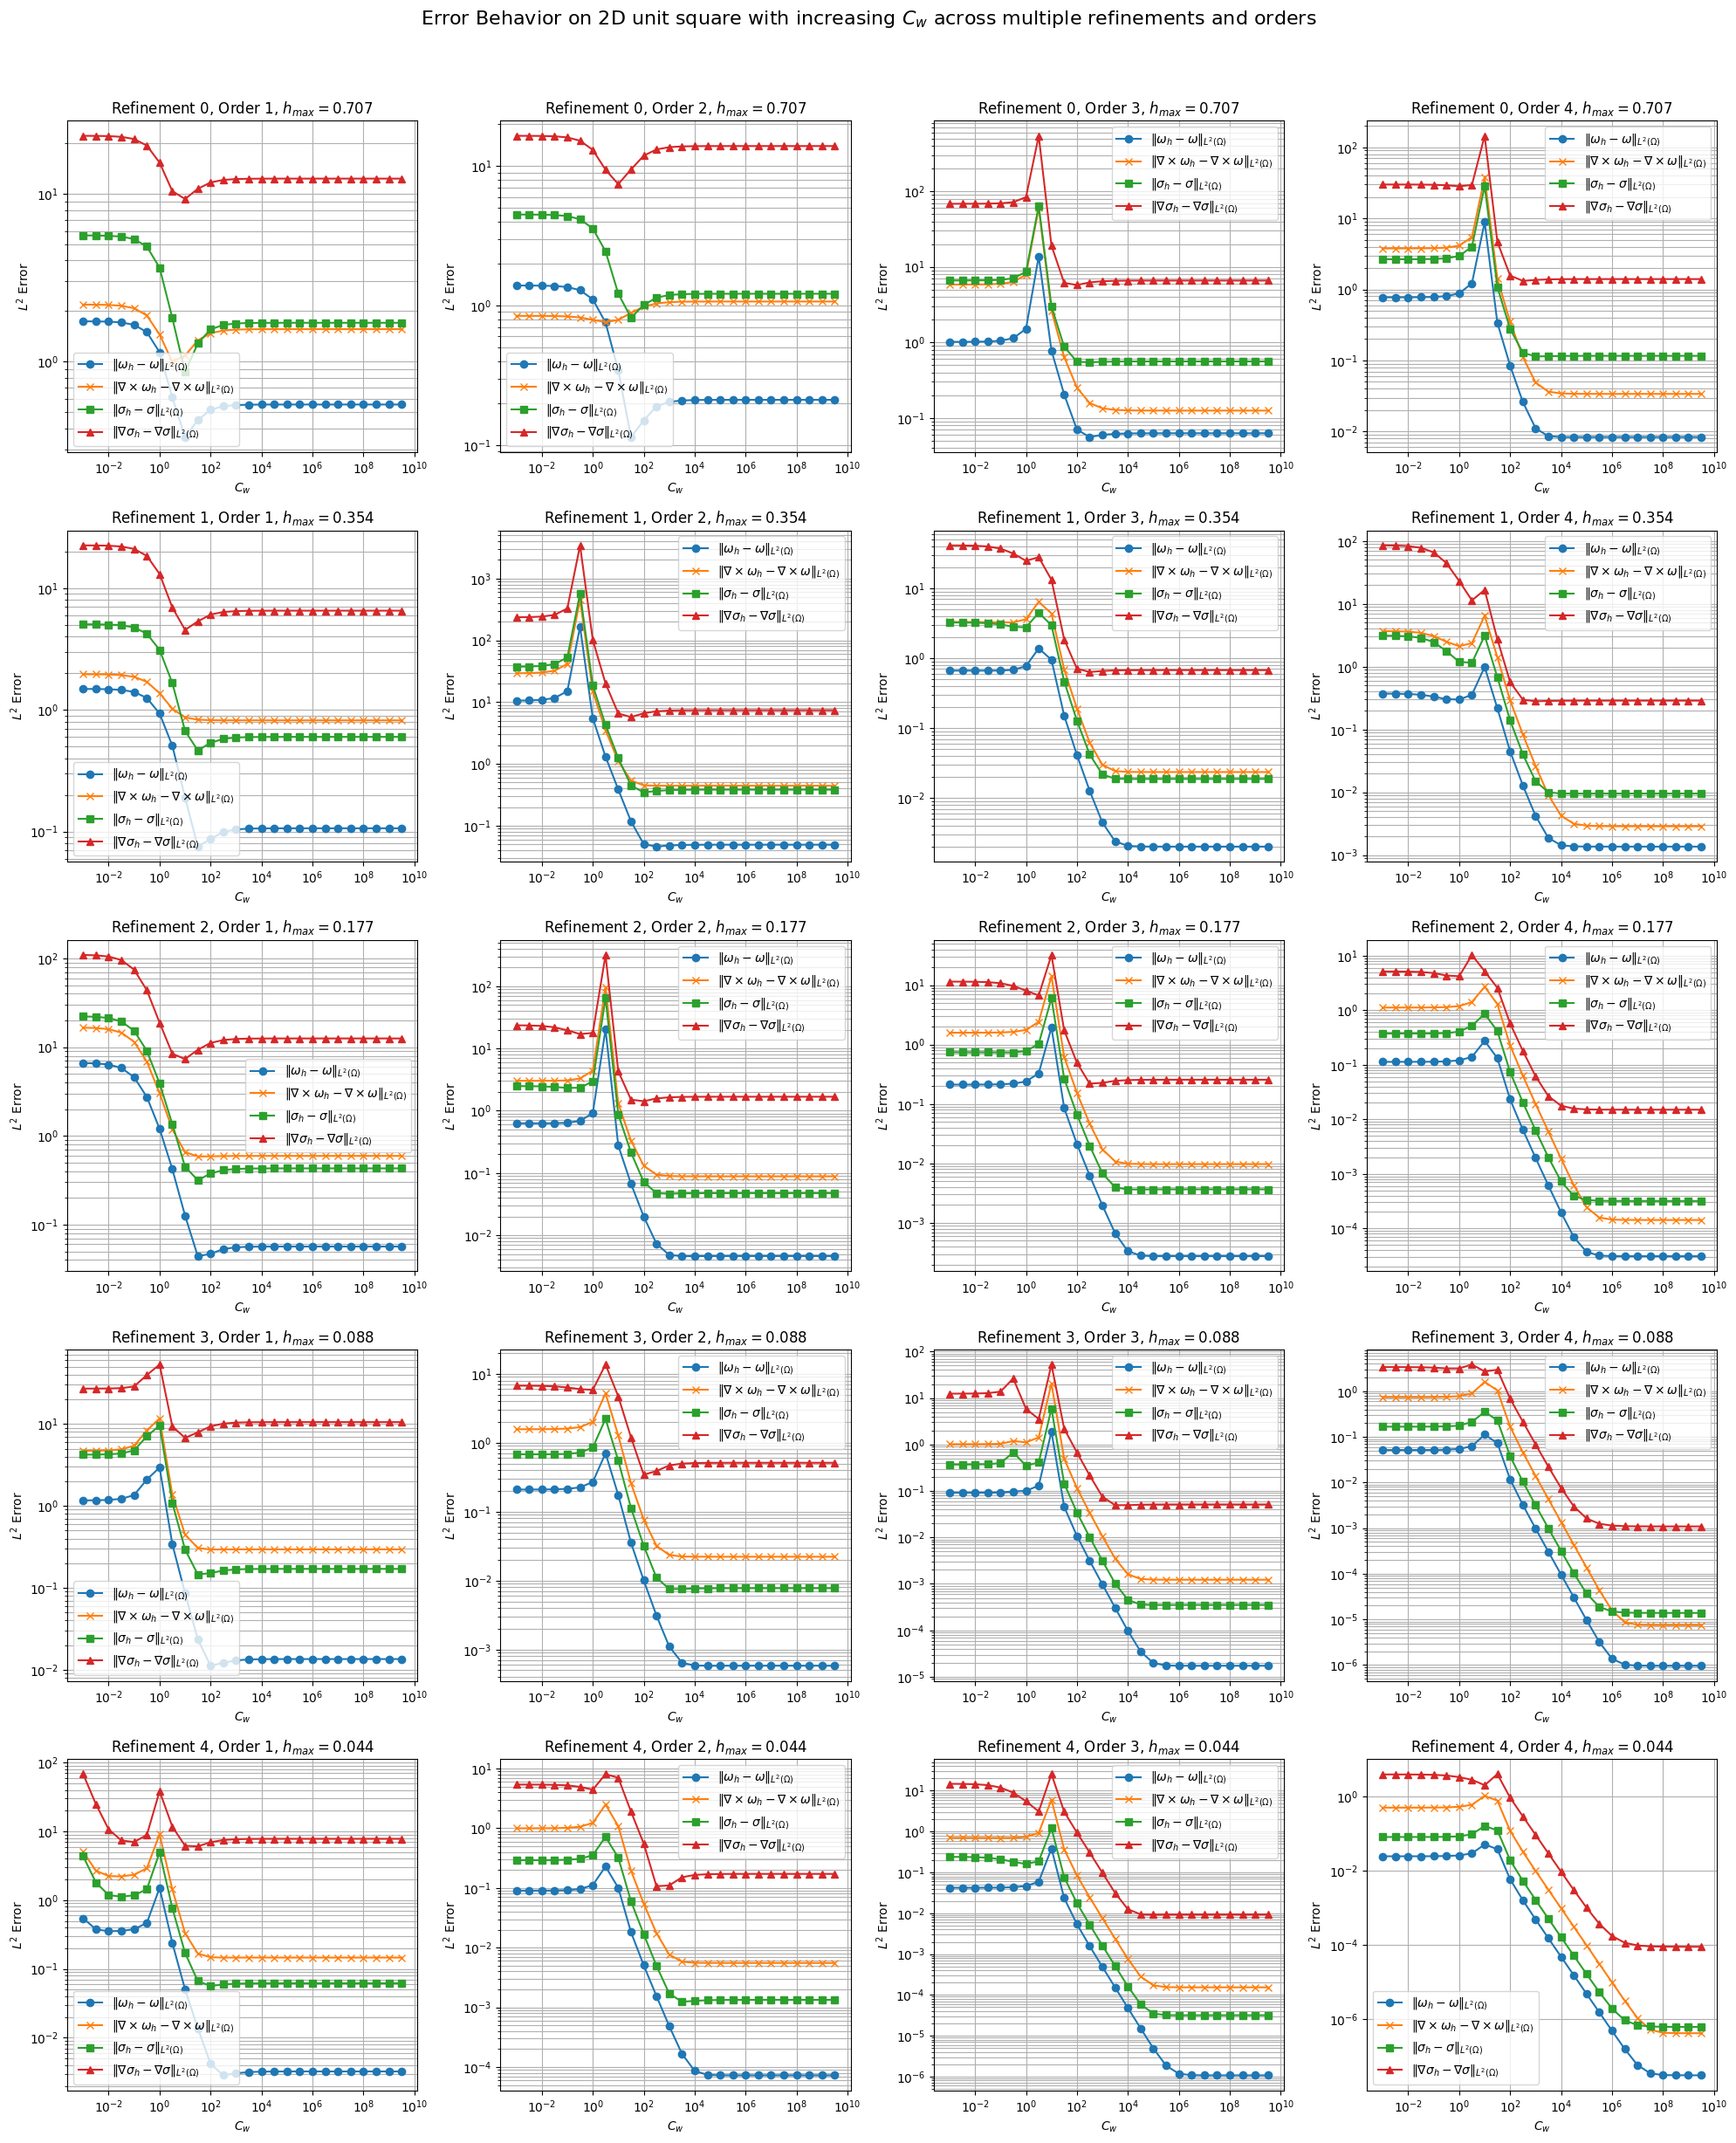

In [74]:
num_refinements = refinement_steps
num_orders = len(orders)

fig, axs = plt.subplots(num_refinements, num_orders, figsize=(20, 5 * num_refinements))
fig.suptitle("Error Behavior on 2D unit square with increasing $C_w$ across multiple refinements and orders", fontsize=16)

for refinement_step in range(num_refinements):
    for i, order in enumerate(orders):
        ax = axs[refinement_step, i]
        df = results_cw_2D[refinement_step * num_orders + i]
        
        hmax_value = round(maxh_values[refinement_step], 3)

        line_omega, = ax.plot(df['C_w'], df['L2_error_omega'], label=r'$\Vert \omega_h - \omega \Vert_{L^2(\Omega)}$', marker='o')
        line_curl_omega, = ax.plot(df['C_w'], df['L2_error_curl_omega'], label=r'$\Vert \nabla \times \omega_h - \nabla \times \omega \Vert_{L^2(\Omega)}$', marker='x')
        line_sigma, = ax.plot(df['C_w'], df['L2_error_sigma'], label=r'$\Vert \sigma_h - \sigma \Vert_{L^2(\Omega)}$', marker='s')
        line_grad_sigma, = ax.plot(df['C_w'], df['L2_error_grad_sigma'], label=r'$\Vert \nabla \sigma_h - \nabla \sigma \Vert_{L^2(\Omega)}$', marker='^')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('$C_w$')
        ax.set_ylabel('$L^2$ Error')
        ax.grid(True, which='both', axis='both')
        ax.set_title(f'Refinement {refinement_step}, Order {order}, $h_{{max}} = {hmax_value}$')
        ax.legend(handles=[line_omega, line_curl_omega, line_sigma, line_grad_sigma])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Data Generation for plots!

In [67]:
Cw_val = 10**6
omega_m = omega_m_sinusoids_2D

order = np.linspace(1, 4, 4)

mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))
h_max_eval = calc_hmax(mesh)
print("hmax when starting out is: ", h_max_eval)

results_h_2D = []

for i in range(0, 4):
    if i > 0:
        mesh.Refine()
        h_max_eval = calc_hmax(mesh)
        pass

    print("doing h ", h_max_eval)
    for order_mesh in order:
        ndof, res, L2_error_omega, L2_error_curl_omega, L2_error_sigma, L2_error_grad_sigma = hodgeLaplace1Forms(
            mesh,
            omega_m,
            order=order_mesh,
            C_w=Cw_val
        )
        
        results_h_2D.append({
            'order': order_mesh,
            'hmax': h_max_eval,
            'C_w': Cw_vals,
            'ndof': ndof,
            'res': res,
            'L2_error_omega': L2_error_omega,
            'L2_error_curl_omega': L2_error_curl_omega,
            'L2_error_sigma': L2_error_sigma,
            'L2_error_grad_sigma': L2_error_grad_sigma
        })

df = pd.DataFrame(results_h_2D)

hmax when starting out is:  0.07880697561787388
doing h  0.07880697561787388
doing h  0.06000704161476892
doing h  0.030003520807384474
doing h  0.015001760403692256


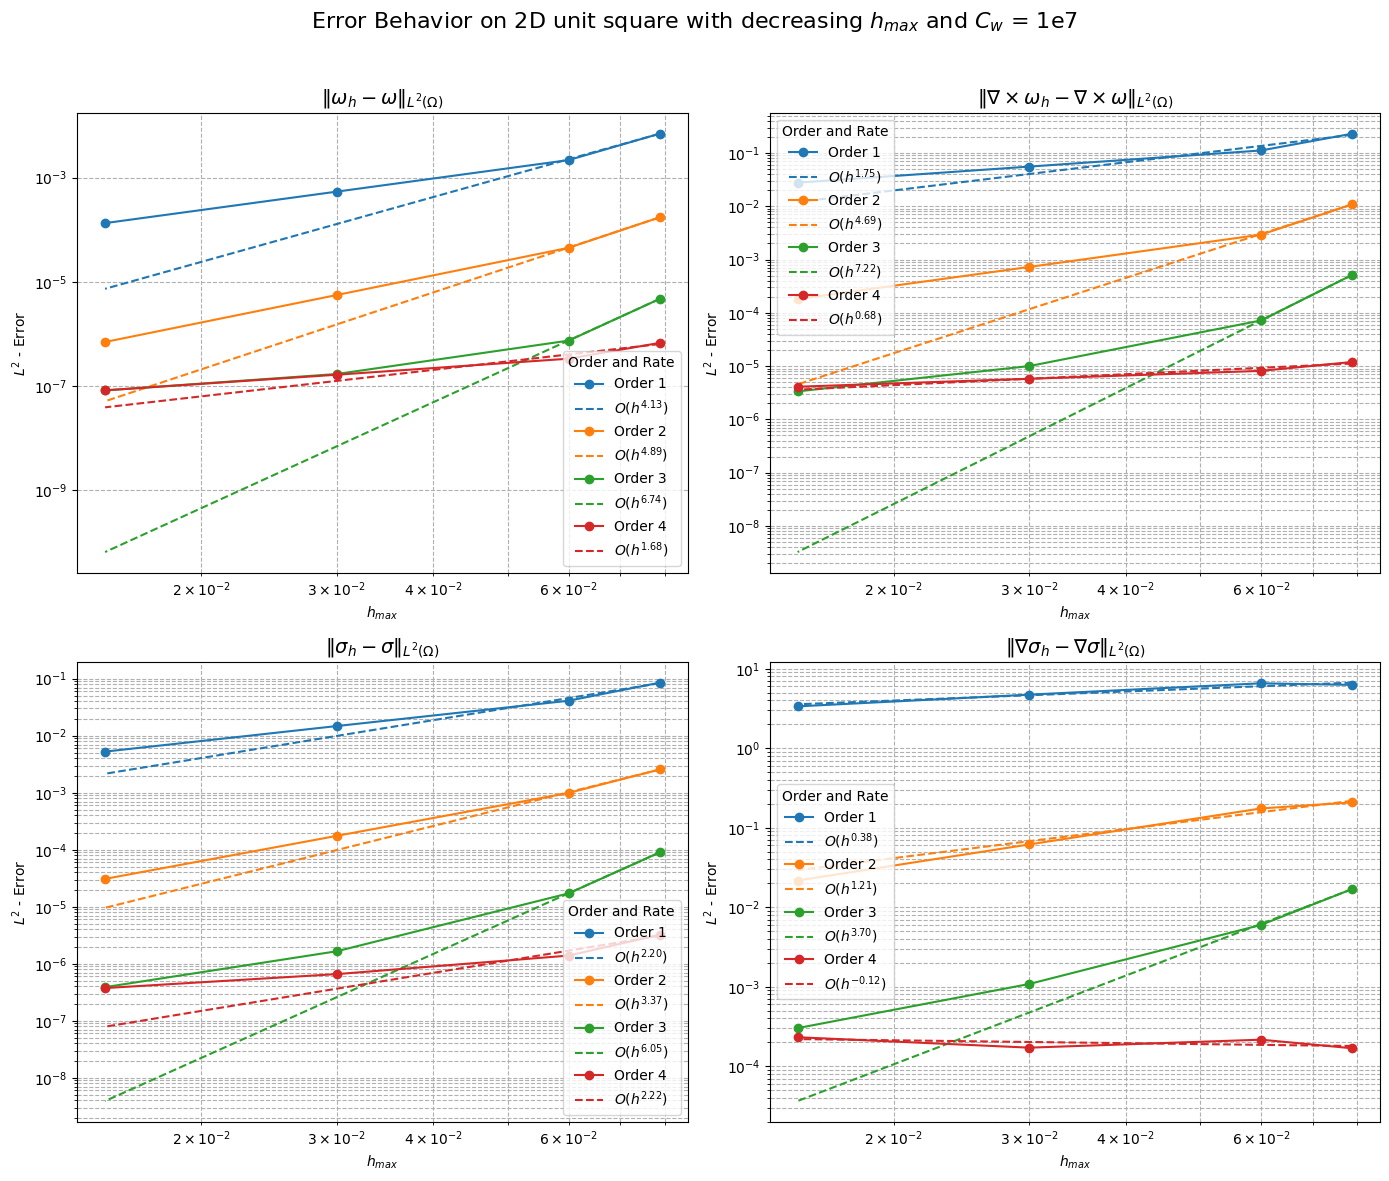

In [68]:
error_columns = ['L2_error_omega', 'L2_error_curl_omega', 'L2_error_sigma', 'L2_error_grad_sigma']
error_titles = [
    r'$\Vert \omega_h - \omega \Vert_{L^2(\Omega)}$',
    r'$\Vert \nabla \times \omega_h - \nabla \times \omega \Vert_{L^2(\Omega)}$',
    r'$\Vert \sigma_h - \sigma \Vert_{L^2(\Omega)}$',
    r'$\Vert \nabla \sigma_h - \nabla \sigma \Vert_{L^2(\Omega)}$'
]

fig, axs = plt.subplots(2, 2, figsize=(14, 12))  
fig.suptitle('Error Behavior on 2D unit square with decreasing $h_{max}$ and $C_w$ = 1e7', fontsize=16)

for i, (error_col, title) in enumerate(zip(error_columns, error_titles)):
    ax = axs[i // 2, i % 2]

    for order_mesh, group in df.groupby('order'):
        h_values = group['hmax'].values
        error_values = group[error_col].values

        error_line, = ax.plot(h_values, error_values, label=f'Order {int(order_mesh)}', marker='o')
        line_color = error_line.get_color()

        scaling_factor, slope = fit_reference_line(h_values, error_values)

        reference_values = scaling_factor * h_values ** slope
        ax.plot(h_values, reference_values, linestyle='--', color=line_color, label=f'$O(h^{{{slope:.2f}}})$')

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(r'$h_{max}$')
    ax.set_ylabel(r'$L^2$ - Error')
    ax.set_title(title, fontsize=14)

    ax.grid(True, which='both', linestyle='--')
    ax.legend(title="Order and Rate")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [69]:
# Cw_vals = logspace_custom_decades(0.955, 10.005, 2) 
# hmax_cw = 0.1
# orders = [1] 

# results_cw_3D = []

# geo = CSGeometry()
# box = OrthoBrick(Pnt(-1, -1, -1), Pnt(1, 1, 1))
# geo.Add(box)
# mesh = Mesh(geo.GenerateMesh(maxh=hmax_cw))

# for order_cw in orders:
#     results_cw = []
#     #print("Running order ", order_cw)
    
#     for C_w in Cw_vals:
#         #print("for Cw ", C_w)
        
#         #omega_m = omega_m_gauss_pulse_3D
#         omega_m = omega_m_sinusoids_3D
#         ndof, res, L2_error_omega, L2_error_curl_omega, L2_error_sigma, L2_error_grad_sigma = hodgeLaplace1Forms(mesh, omega_m, order=order_cw, C_w=C_w)
        
#         results_cw.append({
#             'order': order_cw,
#             'hmax': hmax_cw,
#             'C_w': C_w,
#             'ndof': ndof,
#             'res': res,
#             'L2_error_omega': L2_error_omega,
#             'L2_error_curl_omega': L2_error_curl_omega,
#             'L2_error_sigma': L2_error_sigma,
#             'L2_error_grad_sigma': L2_error_grad_sigma
#         })

#     df_cw_3D = pd.DataFrame(results_cw)
#     results_cw_3D.append(df_cw_3D)

In [70]:
# #print(results_cw_3D['ndof'])
# fig, axs = plt.subplots(2, 2, figsize=(15, 13))
# fig.suptitle("Error Behavior on 3D OrthoBrick with increasing $C_w$ at h=0.2")

# for i, order in enumerate(orders):
#     ax = axs[i // 2, i % 2]
#     df = results_cw_3D[i]
    
#     # L2 error for curent order
#     ax.plot(df['C_w'], df['L2_error_omega'], label='L2 Error Omega', marker='o')
#     ax.plot(df['C_w'], df['L2_error_curl_omega'], label='L2 Error Curl Omega', marker='x')
#     ax.plot(df['C_w'], df['L2_error_sigma'], label='L2 Error Sigma', marker='s')
#     ax.plot(df['C_w'], df['L2_error_grad_sigma'], label='L2 Error Grad Sigma', marker='^')

#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     ax.set_xlabel('$C_w$') 
#     ax.set_ylabel('$L^2$ Error')
#     ax.grid(True, which='both', axis='both')
#     ax.set_title(f'Order {order}')
    
#     ax.legend([r'$\Vert \omega_h - \omega \Vert_{L^2(\Omega)}$',
#                r'$\Vert \, \nabla \times \omega_h - \nabla \times \omega \, \Vert_{L^2(\Omega)}$',
#                r'$\Vert \sigma_h - \sigma \Vert_{L^2(\Omega)}$',
#                r'$\Vert \, \nabla \sigma_h - \nabla \sigma \, \Vert_{L^2(\Omega)}$'])

# plt.tight_layout()
# plt.show()

In [71]:
# Cw_val_3D = 10
# omega_m = omega_m_sinusoids_3D

# order = np.linspace(1, 3, 3)
# maxh = [0.45, 0.35, 0.25, 0.15]

# results_h_3D = []

# geo = CSGeometry()
# box = OrthoBrick(Pnt(-1, -1, -1), Pnt(1, 1, 1))
# geo.Add(box)

# for hmax in maxh:
#     for order_mesh in order:
#         mesh = Mesh(geo.GenerateMesh(maxh=hmax))

#         ndof, res, L2_error_omega, L2_error_curl_omega, L2_error_sigma, L2_error_grad_sigma = hodgeLaplace1Forms(
#             mesh, 
#             omega_m, 
#             order=order_mesh, 
#             C_w=Cw_val_3D
#         )
        
#         results_h_3D.append({
#             'order': order_mesh,
#             'hmax': hmax,
#             'C_w': Cw_val_3D,
#             'ndof': ndof,
#             'res': res,
#             'L2_error_omega': L2_error_omega,
#             'L2_error_curl_omega': L2_error_curl_omega,
#             'L2_error_sigma': L2_error_sigma,
#             'L2_error_grad_sigma': L2_error_grad_sigma
#         })

# df_3D = pd.DataFrame(results_h_3D)

In [72]:
# error_columns = ['L2_error_omega', 'L2_error_curl_omega', 'L2_error_sigma', 'L2_error_grad_sigma']
# error_titles = [
#     r'$\Vert \omega_h - \omega \Vert_{L^2(\Omega)}$',
#     r'$\Vert \nabla \times \omega_h - \nabla \times \omega \Vert_{L^2(\Omega)}$',
#     r'$\Vert \sigma_h - \sigma \Vert_{L^2(\Omega)}$',
#     r'$\Vert \nabla \sigma_h - \nabla \sigma \Vert_{L^2(\Omega)}$'
# ]

# fig, axs = plt.subplots(2, 2, figsize=(14, 12))  
# fig.suptitle('Error Behavior with decreasing $h_{max}$ in 3D', fontsize=16)

# for i, (error_col, title) in enumerate(zip(error_columns, error_titles)):
#     ax = axs[i // 2, i % 2]

#     for order_mesh, group in df_3D.groupby('order'):
#         ax.plot(group['hmax'], group[error_col], label=f'Order {int(order_mesh)}', marker='o')

#     h_ref = np.array(sorted(df_3D['hmax'].unique()))
#     ax.plot(h_ref, h_ref**1, label=r'$O(h_{max})$', linestyle='--', color='black')
#     ax.plot(h_ref, h_ref**2, label=r'$O(h_{max}^{2})$', linestyle='--', color='red')

#     ax.set_xscale('log')
#     ax.set_yscale('log')

#     ax.set_xlabel(r'$h_{max}$')
#     ax.set_ylabel(r'$L^2$ - Error')
#     ax.set_title(title, fontsize=14)

#     ax.grid(True, which='both', linestyle='--')
#     ax.legend(title="Order and Rate")

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()